In [2]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
from torchvision.utils import save_image
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
model = models.vgg19(pretrained = True).features

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

In [4]:
model

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [5]:
device = torch.device('cuda')

In [6]:
class VGG(nn.Module):
    def __init__(self):
        super(VGG,self).__init__()
        self.req_features= ['0','5','10','19','28']
        self.model=models.vgg19(pretrained=True).features[:29]
    def forward(self, x):
        features = []
        for layer_num, layer in enumerate(self.model):
          x = layer(x)
          if (str(layer_num) in self.req_features):
            features.append(x)
        return features


In [7]:
!wget file:///Users/honordimond/Library/CloudStorage/OneDrive-DurhamUniversity/Digital%20Humanities/Digital%20Humanities/Project/48310494586_68ecb95c83_b.jpeg.jpeg
!wget file:///Users/honordimond/Library/CloudStorage/OneDrive-DurhamUniversity/Digital%20Humanities/Digital%20Humanities/Project/impression-sunrise.jpg!Large.jpg.jpeg

file:///Users/honordimond/Library/CloudStorage/OneDrive-DurhamUniversity/Digital%20Humanities/Digital%20Humanities/Project/48310494586_68ecb95c83_b.jpeg.jpeg: Unsupported scheme ‘file’.
file:///Users/honordimond/Library/CloudStorage/OneDrive-DurhamUniversity/Digital%20Humanities/Digital%20Humanities/Project/impression-sunrise.jpg!Large.jpg.jpeg: Unsupported scheme ‘file’.


In [8]:
def image_loader(orig_path, style_path):
    orig_image=Image.open(orig_path)
    style_image=Image.open(style_path)
    f, axarr = plt.subplots(2,2)
    axarr[0,0].imshow(orig_image)
    axarr[0,1].imshow(style_image)

    width, height = orig_image.size
    img_height = 235
    img_width = int(width * img_height / height)

    loader=transforms.Compose([transforms.Resize((img_height,img_width)),transforms.ToTensor()])

    orig_image=loader(orig_image)
    axarr[1,0].imshow(  orig_image.permute(1, 2, 0)  )
    orig_image=orig_image.unsqueeze(0)
    style_image=loader(style_image)
    axarr[1,1].imshow(  style_image.permute(1, 2, 0)  )
    style_image=style_image.unsqueeze(0)
    return orig_image.to(device,torch.float), style_image.to(device,torch.float)

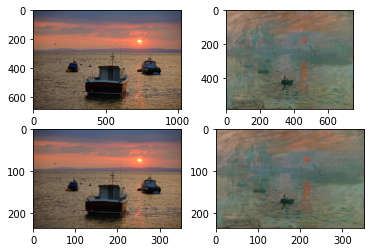

In [9]:
original_image, style_image = image_loader('48310494586_68ecb95c83_b.jpeg', 'impression-sunrise.jpg!Large.jpg')

In [10]:
generated_image=original_image.clone().requires_grad_(True)

In [11]:
def calc_content_loss(gen_feat,orig_feat):
    #calculating the content loss of each layer by calculating the MSE between the content and generated features and adding it to content loss
    content_l=torch.mean((gen_feat-orig_feat)**2)
    return content_l

In [12]:
def calc_style_loss(gen,style):
    #Calculating the gram matrix for the style and the generated image
    batch_size,channel,height,width=gen.shape

    G=torch.mm(gen.view(channel,height*width),gen.view(channel,height*width).t()) #flattening a 3d matrix into a 2d matrix.
    A=torch.mm(style.view(channel,height*width),style.view(channel,height*width).t())
        
    #Calculating the style loss of each layer by calculating the MSE between the gram matrix of the style image and the generated image and adding it to style loss
    style_l=torch.mean((G-A)**2) #mean of the square of the difference
    return style_l


In [13]:
def calculate_loss(gen_features, orig_features, style_features):
    style_loss=content_loss=0
    for gen,cont,style in zip(gen_features,orig_features,style_features):
        #extracting the dimensions from the generated image
        content_loss+=calc_content_loss(gen,cont)
        style_loss+=calc_style_loss(gen,style)
    
    #calculating the total loss of e th epoch
    total_loss=alpha*content_loss + beta*style_loss 
    return total_loss

In [14]:
model=VGG().to(device).eval()

In [15]:
epoch=1000
lr=0.004
alpha=8
beta=70

In [16]:
original_image = original_image.cuda()
style_image = style_image.cuda()

orig_features = model(original_image)
style_features = model(style_image)

In [17]:
optimizer=optim.Adam([generated_image],lr=lr)

tensor(6.8814e+08, device='cuda:0', grad_fn=<AddBackward0>)
tensor(7697982., device='cuda:0', grad_fn=<AddBackward0>)
tensor(2698567., device='cuda:0', grad_fn=<AddBackward0>)
tensor(1545845.5000, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1076816.1250, device='cuda:0', grad_fn=<AddBackward0>)
tensor(826437.6875, device='cuda:0', grad_fn=<AddBackward0>)
tensor(670802.6250, device='cuda:0', grad_fn=<AddBackward0>)
tensor(566623.8750, device='cuda:0', grad_fn=<AddBackward0>)
tensor(492729., device='cuda:0', grad_fn=<AddBackward0>)
tensor(437788.8125, device='cuda:0', grad_fn=<AddBackward0>)


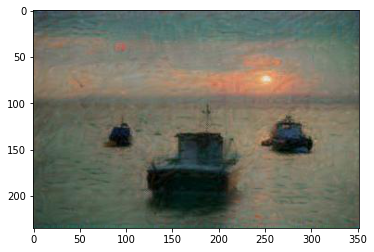

In [18]:
#iterating for 1000 times
for e in range (epoch):
    # Extracting the features of generated image required for 
    # calculating the loss. 
    gen_features=model(generated_image)

    #iterating over the activation of each layer and calculate the loss and add it to the content and the style loss
    total_loss=calculate_loss(gen_features, orig_features, style_features)
    #optimize the pixel values of the generated image and backpropagate the loss
    optimizer.zero_grad()
    # Retain graph, since otherwise orig_features and style_features would
    # be thrown away after, but we need them for each iteration
    total_loss.backward(retain_graph=True)
    optimizer.step()
    
    #print the image and save it after each 100 epoch
    if(not (e%100)):
        print(total_loss)
        
        save_image(generated_image,"gen.jpg")

img = plt.imread("gen.jpg")
plt.imshow(img)
    

# New section

In [19]:
model2 = models.vgg19(pretrained = True).features

In [20]:
model2

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [21]:
device2 = torch.device('cuda')

In [22]:
class VGG(nn.Module):
    def __init__(self):
        super(VGG,self).__init__()
        self.req_features= ['0','5','10','19','28']
        self.model=models.vgg19(pretrained=True).features[:29]
    def forward(self, x):
        features = []
        for layer_num, layer in enumerate(self.model):
          x = layer(x)
          if (str(layer_num) in self.req_features):
            features.append(x)
        return features

In [42]:
!wget file:///Users/honordimond/Library/CloudStorage/OneDrive-DurhamUniversity/Digital%20Humanities/Digital%20Humanities/Project/Comparison-of-Hokusais-Great-wave-with-an-observation-in-sub-Antarctic-water-a-The.jpg
!wget file:///Users/honordimond/Library/CloudStorage/OneDrive-DurhamUniversity/Digital%20Humanities/Digital%20Humanities/Project/The-Great-Wave-2008-acquisition-1000x689.jpeg

file:///Users/honordimond/Library/CloudStorage/OneDrive-DurhamUniversity/Digital%20Humanities/Digital%20Humanities/Project/Comparison-of-Hokusais-Great-wave-with-an-observation-in-sub-Antarctic-water-a-The.jpg: Unsupported scheme ‘file’.
file:///Users/honordimond/Library/CloudStorage/OneDrive-DurhamUniversity/Digital%20Humanities/Digital%20Humanities/Project/The-Great-Wave-2008-acquisition-1000x689.jpeg: Unsupported scheme ‘file’.


In [43]:
def image_loader(orig_path, style_path):
    orig_image=Image.open(orig_path)
    style_image=Image.open(style_path)
    f, axarr = plt.subplots(2,2)
    axarr[0,0].imshow(orig_image)
    axarr[0,1].imshow(style_image)

    width, height = orig_image.size
    img_height = 235
    img_width = int(width * img_height / height)

    loader=transforms.Compose([transforms.Resize((img_height,img_width)),transforms.ToTensor()])

    orig_image=loader(orig_image)
    axarr[1,0].imshow(  orig_image.permute(1, 2, 0)  )
    orig_image=orig_image.unsqueeze(0)
    style_image=loader(style_image)
    axarr[1,1].imshow(  style_image.permute(1, 2, 0)  )
    style_image=style_image.unsqueeze(0)
    return orig_image.to(device,torch.float), style_image.to(device,torch.float)

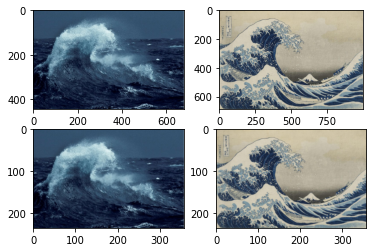

In [45]:
original_image2, style_image2 = image_loader('Comparison-of-Hokusais-Great-wave-with-an-observation-in-sub-Antarctic-water-a-The.jpg', 'The-Great-Wave-2008-acquisition-1000x689.jpeg')

In [46]:
generated_image2=original_image2.clone().requires_grad_(True)

In [47]:
def calc_content_loss(gen_feat,orig_feat):
    #calculating the content loss of each layer by calculating the MSE between the content and generated features and adding it to content loss
    content_l=torch.mean((gen_feat-orig_feat)**2)
    return content_l

In [48]:
def calc_style_loss(gen,style):
    #Calculating the gram matrix for the style and the generated image
    batch_size,channel,height,width=gen.shape

    G=torch.mm(gen.view(channel,height*width),gen.view(channel,height*width).t()) #flattening a 3d matrix into a 2d matrix.
    A=torch.mm(style.view(channel,height*width),style.view(channel,height*width).t())
        
    #Calculating the style loss of each layer by calculating the MSE between the gram matrix of the style image and the generated image and adding it to style loss
    style_l=torch.mean((G-A)**2) #mean of the square of the difference
    return style_l

In [49]:
def calculate_loss(gen_features, orig_features, style_features):
    style_loss=content_loss=0
    for gen,cont,style in zip(gen_features,orig_features,style_features):
        #extracting the dimensions from the generated image
        content_loss+=calc_content_loss(gen,cont)
        style_loss+=calc_style_loss(gen,style)
    
    #calculating the total loss of e th epoch
    total_loss=alpha*content_loss + beta*style_loss 
    return total_loss

In [50]:
model2=VGG().to(device).eval()

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [51]:
epoch=1000
lr=0.004
alpha=8
beta=70

In [52]:
original_image2 = original_image2.cuda()
style_image2 = style_image2.cuda()

orig_features2 = model2(original_image2)
style_features2 = model2(style_image2)

In [53]:
optimizer=optim.Adam([generated_image2],lr=lr)

tensor(1.6204e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(70962368., device='cuda:0', grad_fn=<AddBackward0>)
tensor(34541476., device='cuda:0', grad_fn=<AddBackward0>)
tensor(24769808., device='cuda:0', grad_fn=<AddBackward0>)
tensor(20820736., device='cuda:0', grad_fn=<AddBackward0>)
tensor(18619768., device='cuda:0', grad_fn=<AddBackward0>)
tensor(17078940., device='cuda:0', grad_fn=<AddBackward0>)
tensor(15856644., device='cuda:0', grad_fn=<AddBackward0>)
tensor(14817394., device='cuda:0', grad_fn=<AddBackward0>)
tensor(13894007., device='cuda:0', grad_fn=<AddBackward0>)


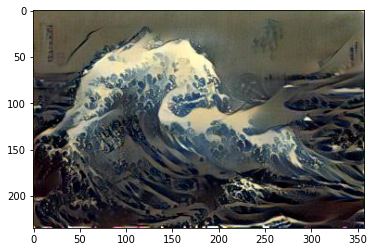

In [54]:
#iterating for 1000 times
for e in range (epoch):
    # Extracting the features of generated image required for 
    # calculating the loss. 
    gen_features=model2(generated_image2)

    #iterating over the activation of each layer and calculate the loss and add it to the content and the style loss
    total_loss=calculate_loss(gen_features, orig_features2, style_features2)
    #optimize the pixel values of the generated image and backpropagate the loss
    optimizer.zero_grad()
    # Retain graph, since otherwise orig_features and style_features would
    # be thrown away after, but we need them for each iteration
    total_loss.backward(retain_graph=True)
    optimizer.step()
    
    #print the image and save it after each 100 epoch
    if(not (e%100)):
        print(total_loss)
        
        save_image(generated_image2,"gen.jpg")

img2 = plt.imread("gen.jpg")
plt.imshow(img2)